# Demo Algoritmos Genéticos para optimizar predictores (sin librerías)

Se presentan algunas herramientas didácticas y funcionales, para comprender uno de los casos de aplicación de los Algoritmos Genéticos.

## Clases desde cero

Implementación en Python basada en: https://www.cienciadedatos.net/documentos/py03_seleccion_predictores_ga

### Importaciones

In [1]:
################################################################################
#               SELECCIÓN DE PREDICTORES CON ALGORITMO GENÉTICO                #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8

#%%
################################################################################
#                          LIBRERÍAS NECESARIAS                                #
################################################################################
import numpy as np
import random
import warnings
import copy
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import rankdata
from sklearn import datasets, metrics
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit

### Individuo

In [2]:
#%%
################################################################################
#                              CLASE INDIVIDUO                                 #
################################################################################

class Individuo:
    """
    Esta clase representa un individuo con una determinada selección de
    predictores.

    Parameters
    ----------
    n_variables : `int`
        longitud del array que define al individuo. Debe coincidir con el
        número total de predictores disponibles.

    n_max: `int`, optional
        número máximo de predictores que puede contener inicialmente un individuo.
        Si no se indica un valor (default ``None``) se emplea `n_variables`.

    n_min: `int`, optional
        número mínimo de predictores que puede contener un individuo. (default 1)

    n_max_estricto: `bool`, optional
        forzar a que el individuo no pueda contener más de `n_max` predictores.
        (default ``False``) Ver notas para más info.

    verbose : `bool`, optional
        mostrar información del proceso por pantalla. (default ``False``)

    Attributes
    ----------
    n_variables : `int`
        longitud del array que define al individuo. Debe coincidir con el
        número total de predictores disponibles.

    n_max: `int`
        número máximo de predictores que puede contener inicialmente un individuo.
        Si no se indica un valor (default ``None``) se emplea `n_variables`.

    n_max_estricto: `bool`, optional
        forzar a que el individuo no pueda contener más de `n_max` predictores.
        (default ``False``) Ver notas para más info.

    n_min: `int`
        número mínimo de predictores que puede contener un individuo. (default 1)

    secuencia: `numpy.ndarray`
        array de ``True`` y ``False`` que define las columnas que incluye y
        excluye como predictores el individuo.

    predictores: `numpy.ndarray`
        array con el índice de las columnas empleadas como predictores.

    fitness : `float`
        valor de fitness del individuo.

    metrica : {"neg_mean_squared_error","neg_mean_absolute_error", "f1", "accuracy"}
        métrica de evaluación con la que se calcula el fitness.

    valor_metrica : `float`
        valor de la métrica empleada para calcular el fitness.

    n_predictores_incluidos: `int`
        número de predictores que incluye el individuo.

    modelo: {lineal, logistico, randomforest}
        modelo empleado para evaluar al individuo.

    tipo_modelo: {regresion, clasificacion}
        tipo de modelo (regresión o clasificación)

    Raises
    ------
    raise Exception
        si `n_max` es distinto de ``None`` y mayor que `n_variables`.

    raise Exception
        si `metrica` es distinto de "neg_mean_squared_error",
        "neg_mean_absolute_error", "f1" o "accuracy".

    Notes
    -----

    El argumento `n_max` establece el número máximo de predictores que puede
    incluir el individuo en el momento de su creación. Sin emabrgo, como resultado
    de cruces y mutaciones, los individuos creados en posteriores generaciones
    pueden exceder este valor. Con `n_max_estricto` = ``True`` se fuerza a que
    el número de predictores incluidos nunca supere `n_max`. Para lograrlo,
    tras el proceso de cruce y mutación, si el número de ``True`` en la secuencia
    del individuo supera `n_max`, se cambian a ``False`` tantas posiciones
    (seleccionadas aleatoriamente) hasta que cumplan la condición de `n_max`.

    Examples
    --------
    Ejemplo creación individuo.

    >>> individuo = Individuo(
                        n_variables = 5,
                        n_max = 4,
                        n_min = 1,
                        n_max_estricto = False,
                        verbose = True
                    )

    """

    def __init__(self, n_variables, n_max=None, n_min=1, n_max_estricto=False,
                 verbose=False):

        # Número de variables del individuo
        self.n_variables = n_variables
        # Número máximo de predictores incluidos
        self.n_max = n_max
        self.n_max_estricto = n_max_estricto
        # Número mínimo de predictores incluidos
        self.n_min = n_min
        # Secuencia del individuo
        self.secuencia = None
        # Índices de las columans empleadas como predictores
        self.predictores = None
        # Número predictores incluidos
        self.n_predictores_incluidos = None
        # Fitness del individuo
        self.fitness = None
        # Métrica
        self.metrica = None
        # Valor de la métrica con la que se calcula el fitness
        self.valor_metrica = None
        # Modelo empleado para evaluar el individuo
        self.modelo = None
        # Tipo de modelo: regresion o clasificación
        self.tipo_modelo = None

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if self.n_max is not None and self.n_max > self.n_variables:
            raise Exception(
                "El valor de n_max no puede ser superior al de n_variables"
            )

        # COMPROBACIONES INICIALES: ACCIONES
        # ----------------------------------------------------------------------
        # Si no se especifica n_max, se emplea por defecto el valor de
        # n_variables.
        if self.n_max is None:
            self.n_max = n_variables

        # CREACIÓN DE LA SECUENCIA BOLEANA QUE DEFINE AL INDIVIDUO
        # ----------------------------------------------------------------------
        # Se crea un array boleano que representa el individuo.
        self.secuencia =  np.full(
                            shape      = self.n_variables,
                            fill_value = False,
                            dtype      = "bool"
                          )
        # Se selecciona (con igual probabilidad) el número de valores TRUE
        # que puede tener el individuo, dentro del rango acotado por n_min y
        # n_max.
        n_true = np.random.randint(
                    low  = self.n_min,
                    high = self.n_max + 1,
                    size = None)

        # Se sustituyen n_true posiciones aleatorias por valores True.
        posiciones_true = np.random.choice(
                            a       = self.n_variables,
                            size    = n_true,
                            replace = False
                          )
        self.secuencia[posiciones_true] = True
        self.n_predictores_incluidos    = sum(self.secuencia)

        # Se identifican los indices de las posiciones True
        self.predictores = np.arange(self.n_variables)[self.secuencia]

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------------")
            print("Nuevo individuo creado")
            print("----------------------")
            print("Secuencia: " + str(self.secuencia))
            print("Índice predictores: " + str(self.predictores))
            print("Número de predictores incluidos: " \
                  + str(self.n_predictores_incluidos))
            print("Fitness: " + str(self.fitness))
            print("Métrica: "+ str(self.metrica))
            print("Valor métrica: "+ str(self.valor_metrica))
            print("Modelo empleado para calcular fitness: " \
                  + str(self.modelo))
            print("Tipo de modelo: " + str(self.tipo_modelo))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto Individuo.

        """

        texto = "Individuo" \
                + "\n" \
                + "---------" \
                + "\n" \
                + "Secuencia: " + str(self.secuencia) \
                + "\n" \
                + "Índice predictores: " + str(self.predictores) \
                + "\n" \
                + "Número de predictores incluidos: " \
                + str(self.n_predictores_incluidos) \
                + "\n" \
                + "Fitness: " + str(self.fitness) \
                + "\n" \
                + "Métrica: " + str(self.metrica) \
                + "\n" \
                + "Valor métrica: " + str(self.valor_metrica) \
                + "\n" \
                + "Modelo empleado para calcular fitness: " + str(self.modelo) \
                + "\n" \
                + "Tipo de modelo: " + str(self.tipo_modelo) \
                + "\n"

        return(texto)

    def evaluar_individuo(self, x, y, tipo_modelo, modelo, metrica, cv=5,
                          test_size=0.2, cv_seed=123, nivel_referencia = None,
                          rf_n_estimators = 100, verbose = False):
        """Este método calcula el fitness del individuo a partir del valor de la
        métrica obtenida por `ShuffleSplit` al ajustar un modelo empleando los
        predictores que indica su secuencia.

        Parameters
        ----------
        x : `numpy array 2d`
            matriz con el valor de los predictores.

        y : `numpy array 1d`
            numpy array con la variable respuesta.

        cv : `int`
            número de repeticiones para la validación. EL método empleado es
            `ShuffleSplit` de scikit-learn, que es distinto a `Kfold`.
            (default 5)

        test_size : `float`
            porcentaje de observaciones empleadas como test en cada validación.
            (default 0.2)

        cv_seed : `int`
            semilla empleada para el reparto aleatorio en la validación.
            (default 123)

        modelo: {lineal, logistico, randomforest}
            modelo empleado para evaluar al individuo.

        tipo_modelo: {regresion, clasificacion}
            tipo de problema (regresión o clasificación).

        metrica: {"neg_mean_squared_error", "neg_mean_absolute_error", "f1",
                 "accuracy"}
            métrica empleada para calcular el fitness del individuo.

        nivel_referencia : `str`
            valor de la variable respuesta considerado como referencia.
            Necesario cuando la métrica es f1 o kappa. (default ``None``)

        rf_n_estimators : `int`
            número de árboles en los modelos random forest. (default 100)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)

        Raises
        ------

        raise Exception
            si el argumento `metrica` es distinto de "neg_mean_squared_error",
            "neg_mean_absolute_error", "f1" o "accuracy".

        raise Exception
            si el argumento `metrica` es distinto de "neg_mean_squared_error" o
            "neg_mean_absolute_error" y `tipo_modelo` es "regresion".

        raise Exception
            si el argumento `metrica` es distinto de "accuracy" o "f1" y
            `tipo_modelo` es "clasificacion".

        raise Exception
            si el número de columnas de x es distinto al argumento `n_variables`.

        Examples
        --------
        # Regresión:
        >>> boston = datasets.load_boston(return_X_y= True)
        >>> individuo = Individuo(
                            n_variables = 13,
                            n_max       = 3,
                            n_min       = 1,
                            n_max_restricto = False,
                            verbose     = True
                        )
        >>> individuo.evaluar_individuo(
                x  = boston[0],
                y  = boston[1],
                cv = 5,
                test_size = 0.2,
                tipo_modelo = "regresion",
                modelo      = "randomforest",
                metrica     = "neg_mean_squared_error",
                verbose     = True
            )
        >>> individuo

        # Clasificación
        >>> iris = datasets.load_iris()
        >>> individuo = Individuo(
                            n_variables = 4,
                            n_max       = 3,
                            n_min       = 1,
                            n_max_restricto = False,
                            verbose     = True
                        )
        >>> individuo.evaluar_individuo(
                x  = iris.data,
                y  = iris.target,
                cv = 5,
                test_size = 0.2,
                tipo_modelo = "clasificacion",
                modelo      = "randomforest",
                metrica     = "accuracy",
                verbose     = True
            )
        >>> individuo

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if metrica not in ["neg_mean_squared_error",
                           "neg_mean_absolute_error",
                           "f1", "accuracy"]:
            raise Exception(
                "La métrica debe ser: neg_mean_squared_error, " \
                 + "neg_mean_absolute_error, f1 o accuracy"
            )

        if self.n_variables != x.shape[1]:
            raise Exception(
                "n_variables debe ser igual al número de columnas de x."
            )

        if not isinstance(x, np.ndarray) or x.ndim != 2:
            raise Exception(
                "x debe ser un array numpy de dos dimensiones (una matriz)."
            )
        if not isinstance(y, np.ndarray) or y.ndim != 1:
            raise Exception(
                "y debe ser un array numpy de 1 dimensiones."
            )

        if modelo == "lineal":
            if metrica not in ["neg_mean_squared_error", "neg_mean_absolute_error"]:
                raise Exception(
                "Para el modelo lineal, la metrica debe ser: " \
                + "neg_mean_squared_error, neg_mean_absolute_error."
                )
            if tipo_modelo != "regresion":
                raise Exception(
                "El modelo lineal solo puede aplicarse a problemas de regresión."
                )

        if modelo == "glm":
            if metrica not in ["f1", "accuracy"]:
                raise Exception(
                "Para el modelo glm la métrica de evaluación debe ser f1," \
                + "o accuracy."
                )
            if tipo_modelo != "clasificacion":
                raise Exception(
                "El modelo glm solo puede aplicarse a problemas de clasificación."
                )
            if len(np.unique(y)) != 1:
                raise Exception(
                "El modelo glm solo puede aplicarse a problemas de clasificación" \
                + "binaria."
                )

        # Se identifica el modelo y el tipo
        self.modelo = modelo
        self.tipo_modelo = tipo_modelo
        self.metrica = metrica

        # Se selecciona la clase de scikit-learn correspondiente al modelo
        if self.modelo == "lineal":
            mod = LinearRegression()
        elif self.modelo == "glm":
            mod = LogisticRegression()
        elif self.modelo == "randomforest" and self.tipo_modelo == "regresion":
            mod = RandomForestRegressor(
                    n_estimators = rf_n_estimators,
                    random_state = 1234,
                    bootstrap    = False
                  )
        elif self.modelo == "randomforest" and self.tipo_modelo == "clasificacion":
            mod = RandomForestClassifier(
                    n_estimators = rf_n_estimators,
                    random_state = 1234,
                    bootstrap    = False
                  )

        cv = ShuffleSplit(
                n_splits     = cv,
                test_size    = test_size,
                random_state = cv_seed
             )

        metrica_cv = cross_val_score(
                        estimator = mod,
                        X         = x[:,self.predictores],
                        y         = y,
                        cv        = cv,
                        scoring   = metrica,
                        n_jobs    = 1
                     )

        self.valor_metrica = metrica_cv.mean()
        self.fitness       = metrica_cv.mean()

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido evaluado")
            print("-----------------------------")
            print("Métrica: " + str(self.metrica))
            print("Valor métrica: " + str(self.valor_metrica))
            print("Fitness: " + str(self.fitness))
            print("")

    def mutar(self, prob_mut=0.01, verbose=False):
        """
        Este método somete al individuo a un proceso de mutación en el que, cada
        una de sus posiciones, puede verse modificada con una probabilidad
        `prob_mut`.

        Parameters
        ----------
        prob_mut : `float`, optional
            probabilidad que tiene cada posición del individuo de mutar.
            (default 0.01)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)

        Raises
        ------
        raise Exception
            si el argumento `prob_mut` es está fuera del rango [0,1].

        Examples
        --------
        Ejemplo mutar individuo.

        >>> boston = datasets.load_boston(return_X_y= True)
        >>> individuo = Individuo(
                            n_variables = 13,
                            n_max       = 3,
                            n_min       = 1,
                            verbose     = True
                        )

        >>> individuo.mutar(
                prob_mut = 0.5,
                verbose  = True
            )
        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if prob_mut < 0 or prob_mut > 1:
            raise Exception(
                "El argumento prob_mut debe de estar en el rango [0,1]."
            )

        # SELECCIÓN PROBABILISTA DE POSICIONES (VARIABLES) QUE MUTAN
        #-----------------------------------------------------------------------
        posiciones_mutadas = np.random.uniform(
                                low=0,
                                high=1,
                                size=self.n_variables
                             )
        posiciones_mutadas = posiciones_mutadas < prob_mut

        # Se modifican las posiciones de la secuencia del individuo que coinciden
        # con las posiciones_mutadas.
        self.secuencia[posiciones_mutadas] = \
                np.logical_not(self.secuencia[posiciones_mutadas])

        # Todo individuo debe tener como mínimo 1 predictor, si como consecuencia de la
        # mutación, ningun valor de la secuencia es True, se selecciona una posición
        # aleatoria y se sobreescribe con True.

        if sum(self.secuencia == True) == 0:
            indice = np.random.choice(
                        a       = np.arange(self.n_variables),
                        size    = 1,
                        replace = False
                      )
            self.secuencia[indice] = True

        # Se actualiza el indice de los predictores incluidos.
        self.predictores = np.arange(self.n_variables)[self.secuencia]
        # Se actualiza el número total de predictores incluidos.
        self.n_predictores_incluidos = sum(self.secuencia)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido mutado")
            print("---------------------------")
            print("Total mutaciones: " + str(np.sum(posiciones_mutadas)))
            print("Secuencia: " + str(self.secuencia))
            print("Índice predictores: " + str(self.predictores))
            print("")

    def forzar_n_max(self):
        """
        Este método modifica la secuencia del individuo de forma que, como
        máximo contenga n_max valores True.

        Examples
        --------
        Ejemplo mutar individuo.

        >>> boston = datasets.load_boston(return_X_y= True)
        >>> individuo = Individuo(
                            n_variables = 13,
                            n_max       = 3,
                            n_min       = 1,
                            verbose     = True
                        )

        >>> individuo.mutar(
                prob_mut = 0.5,
                verbose  = True
            )

        >>> individuo.forzar_n_max()
        >>> individuo

        """
        #Se identifica si el número de True es la secuencia supera a n_max.
        n_exceso = sum(self.secuencia) - self.n_max

        if n_exceso > 0:
            # Se seleccionan aleatoriamente n_max posiciones con valor True en
            # la secuencia del individuo.
            indices = np.random.choice(
                        a       = np.flatnonzero(self.secuencia == True),
                        size    = n_exceso,
                        replace = False
                      )
            self.secuencia[indices] = \
                np.logical_not(self.secuencia[indices])

            # Se actualiza el indice de los predictores incluidos.
            self.predictores = np.arange(self.n_variables)[self.secuencia]
            # Se actualiza el número total de predictores incluidos.
            self.n_predictores_incluidos = sum(self.secuencia)

### Población

In [3]:
#%%
################################################################################
#                               CLASE POBLACIÓN                                #
################################################################################

class Poblacion:
    """
    Esta clase crea una población de n individuos.

    Parameters
    ----------
    n_individuos :`int`
        número de individuos de la población.

    n_variables : `int`
        longitud del array que define a los individuos. Debe coincidir con el
        número total de predictores disponibles.

    n_max: `int`, optional
        número máximo de predictores que pueden contener inicialmente los
        individuos. Si no se indica un valor (default ``None``) se emplea
        `n_variables`.

    n_min: `int`, optional
        número mínimo de predictores que pueden contener los individuos.
        (default 1)

    n_max_estricto: `bool`, optional
        forzar a que ningún individuo a lo largo del proceso pueda contener más
        de `n_max` predictores. (default ``False``) Ver notas para más info.

    verbose : `bool`, optional
        mostrar información del proceso por pantalla. (default ``False``)

    Attributes
    ----------
    individuos : `list`
        lista con todos los individuos de la población en su estado actual.

    n_individuos :`int`
        número de individuos de la población.

    n_variables : `int`
        longitud del array que define a los individuos. Debe coincidir con el
        número total de predictores disponibles.

    n_max: `int`, optional
        número máximo de predictores que pueden contener inicialmente los
        individuos. Si no se indica un valor (default ``None``) se emplea
        `n_variables`.

    n_min: `int`, optional
        número mínimo de predictores que pueden contener los individuos.
        (default 1)

    n_max_estricto: `bool`, optional
        forzar a que ningún individuo a lo largo del proceso pueda contener más
        de `n_max` predictores. (default ``False``) Ver notas para más info.

    metrica: {"neg_mean_squared_error", "neg_mean_absolute_error", "f1",
              "accuracy"}
        métrica empleada para calcular el fitness del individuo.

    modelo: {lineal, logistico, randomforest}
            modelo empleado para evaluar al individuo.

    mejor_individuo : `object individuo`
        mejor individuo de la población en su estado actual.

    mejor_fitness : `float`
        fitness del mejor individuo de la población en su estado actual.

    mejor_valor_metrica : `float`
        valor de la métrica del mejor individuo de la población en su
        estado actual.

    mejor_secuencia : `numpy.ndarray`
        secuencia del mejor individuo de la población en su estado actual.

    mejor_predictores : `numpy.ndarray`
        índice de las columnas que incluye como predictores el mejor individuo
        de la población

    historico_individuos : `list`
        lista con la información de todos los individuos en cada una de las
        generaciones que ha tenido la población.

    historico_mejor_secuencia : `list`
        lista con valor de las secuencias del mejor individuo en cada una de las
        generaciones que ha tenido la población.

    historico_mejor_predictores : `list`
        lista con los índice de las columnas que incluye como predictores el
        mejor individuo en cada una de las generaciones que ha tenido la
        población.

    historico_mejor_fitness : `list`
        lista con el mejor fitness en cada una de las generaciones que ha tenido
        la población.

    historico_mejor_valor_metrica : `list`
        lista con valor de la métrica del mejor individuo en cada una
        de las generaciones que ha tenido la población.

    diferencia_abs : `list`
        diferencia absoluta entre el mejor fitness de generaciones consecutivas.

    resultados_df : `pandas.core.frame.DataFrame`
        dataframe con la información del mejor fitness y secuencia encontrada
        en cada generación, así como la diferencia respecto a la generación
        anterior.

    fitness_optimo : `float`
        mejor fitness encontrado tras el proceso de optimización.

    valor_metrica_optimo : `float`
        mejor valor de la métrica encontrado tras el proceso de optimización.

    secuencia_optima : `numpy.narray`
        secuencia con la que se ha conseguido el mejor fitness tras el proceso
        de optimización.

    predictores_optimos : `numpy.narray`
        índice de las columnas que incluye como predictores el individuo con
        mejor fitness tras el proceso de optimización.

    evaluada : `bool`
        si la población ha sido evaluada.

    optimizada : `bool`
        si la población ha sido optimizada.

    iter_optimizacion : `int`
        número de iteraciones de optimización (generaciones).

    Examples
    --------

    Ejemplo crear población

    >>> poblacion = Poblacion(
                        n_individuos = 5,
                        n_variables  = 10,
                        n_max        = 5,
                        n_min        = 1,
                        verbose      = True
                    )
    """

    def __init__(self, n_individuos, n_variables, n_max=None,
                 n_min=1, n_max_estricto=False, verbose=False):

        # Número de individuos de la población
        self.n_individuos = n_individuos
        # Número de variables de cada individuo
        self.n_variables = n_variables
        # Número máximo de predictores incluidos
        self.n_max = n_max
        self.n_max_estricto = n_max_estricto
        # Número mínimo de predictores incluidos
        self.n_min = n_min
        # Métrica utilizada en la evaluación de los individuos
        self.metrica = None
        # Modelo empleado para evaluar el individuo
        self.modelo = None
        # Lista de los individuos de la población
        self.individuos = []
        # Etiqueta para saber si la población ha sido evaluada
        self.evaluada = False
        # Etiqueta para saber si la población ha sido optimizada
        self.optimizada = False
        # Número de iteraciones de optimización llevadas a cabo
        self.iter_optimizacion = None
        # Mejor individuo de la población
        self.mejor_individuo = None
        # Fitness del mejor individuo de la población (el de mayor fitness)
        self.mejor_fitness = None
        # Valor de la métrica del mejor individuo de la población
        self.mejor_valor_metrica = None
        # Secuencia del mejor individuo de la población
        self.mejor_secuencia = None
        # Índice de las columnas que incluye como predictores el mejor individuo
        # de la población
        self.mejor_predictores = None
        # Información de todas los individuos de la población en cada generación
        self.historico_individuos = []
        # Secuencia del mejor individuo en cada generación
        self.historico_mejor_secuencia = []
        # Índice de las columnas que incluye como predictores el mejor individuo
        # en cada generación.
        self.historico_mejor_predictores = []
        # Fitness del mejor individuo en cada generación
        self.historico_mejor_fitness = []
        # Valor de la métrica del mejor individuo en cada generación
        self.historico_mejor_valor_metrica = []
        # Diferencia absoluta entre el mejor fitness de generaciones consecutivas
        self.diferencia_abs = []
        # data.frame con la información del mejor fitness y valor de variables
        # encontrado en cada generación, así como la diferencia respecto a la
        # generación anterior.
        self.resultados_df = None
        # Fitness del mejor individuo de todas las generaciones
        self.fitness_optimo = None
        # Secuencia del mejor individuo de todas las generaciones
        self.secuencia_optima = None
        # Índice de las columnas incluidas como predictores en el mejor individuo
        # de todas las generaciones.
        self.predictores_optimos = None
        # Valor de función objetivo del mejor individuo de todas las generaciones
        self.valor_metrica_optimo = None

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if self.n_max is not None and self.n_max > self.n_variables:
            raise Exception(
                "El valor de n_max no puede ser superior al de n_variables"
            )

        # COMPROBACIONES INICIALES: ACCIONES
        # ----------------------------------------------------------------------
        # Si no se especifica n_max, se emplea por defecto el valor de
        # n_variables.
        if self.n_max is None:
            self.n_max = n_variables

        # SE CREAN LOS INDIVIDUOS DE LA POBLACIÓN Y SE ALMACENAN
        # ----------------------------------------------------------------------
        for i in np.arange(n_individuos):
            individuo_i = Individuo(
                            n_variables = self.n_variables,
                            n_max = self.n_max,
                            n_min = self.n_min,
                            verbose = verbose
                          )
            self.individuos.append(individuo_i)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------")
            print("Población creada")
            print("----------------")
            print("Número de individuos: " + str(self.n_individuos))
            print("Número máximo de predictores iniciales: " + str(self.n_max))
            print("Número mínimo de predictores iniciales: " + str(self.n_min))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto población.
        """

        texto = "============================" \
                + "\n" \
                + "         Población" \
                + "\n" \
                + "============================" \
                + "\n" \
                + "Número de individuos: " + str(self.n_individuos) \
                + "\n" \
                + "Número máximo de predictores iniciales: " + str(self.n_max) \
                + "\n" \
                + "Número mínimo de predictores iniciales: " + str(self.n_min) \
                + "\n" \
                + "Evaluada: " + str(self.evaluada) \
                + "\n" \
                + "Optimizada: " + str(self.optimizada) \
                + "\n" \
                + "Métrica de evaluación: " + str(self.metrica) \
                + "\n" \
                + "Modelo: " + str(self.modelo) \
                + "\n" \
                + "Iteraciones optimización (generaciones): " \
                    + str(self.iter_optimizacion) \
                + "\n" \
                + "\n" \
                + "Información del mejor individuo:" \
                + "\n" \
                + "--------------------------------" \
                + "\n" \
                + "Secuencia: " + str(self.mejor_secuencia) \
                + "\n" \
                + "Índice predictores: " + str(self.mejor_predictores) \
                + "\n" \
                + "Fitness: " + str(self.mejor_fitness) \
                + "\n" \
                + "\n" \
                + "Resultados tras optimizar:" \
                + "\n" \
                + "--------------------------" \
                + "\n" \
                + "Secuencia óptima: " + str(self.secuencia_optima) \
                + "\n" \
                + "Índice predictores óptimos: " + str(self.predictores_optimos) \
                + "\n" \
                + "Valor óptimo métrica: " + str(self.valor_metrica_optimo) \
                + "\n" \
                + "Fitness óptimo: " + str(self.fitness_optimo)

        return(texto)

    def mostrar_individuos(self, n=None):
        """
        Este método muestra la información de cada uno de los n primeros
        individuos de la población.

        Parameters
        ----------
        n : `int`
            número de individuos que se muestran. Si no se indica el valor
            (por defecto ``None``), se muestran todos. Si el valor es mayor
            que `self.n_individuos` se muestran todos.

        Examples
        --------
        >>> poblacion = Poblacion(
                            n_individuos = 5,
                            n_variables  = 10,
                            n_max        = 5,
                            n_min        = 1,
                            verbose      = False
                        )
        >>> poblacion.mostrar_individuos(n = 5)
        """

        if n is None:
            n = self.n_individuos
        elif n > self.n_individuos:
            n = self.n_individuos

        for i in np.arange(n):
            print(self.individuos[i])

        return(None)


    def evaluar_poblacion(self, x, y, tipo_modelo, modelo, metrica, cv=5,
                          test_size=0.2, cv_seed=123, forzar_evaluacion = True,
                          rf_n_estimators=100, nivel_referencia = None, verbose = False):
        """
        Este método calcula el fitness de todos los individuos de la población,
        actualiza sus valores e identifica el mejor.

        Parameters
        ----------
        x : `numpy array 2d`
            matriz con el valor de los predictores.

        y : `numpy array 1d`
            numpy array con la variable respuesta

        cv : `int`
            número de repeticiones para la validación. EL método empleado es
            `ShuffleSplit` de la libreria Scikit-learn, que es distinto a `Kfold`.
            (default 5)

        test_size : `float`
            porcentaje de observaciones empleadas como test en cada validación.
            (default 0.2)

        cv_seed : `int`
            semilla empleada para el reparto aleatorio. (default 123)

        modelo: {lineal, logistico, randomforest}
            modelo empleado para evaluar al individuo.

        tipo_modelo: {regresion, clasificacion}
            tipo de problema (regresión o clasificación)

        metrica: {"neg_mean_squared_error", "neg_mean_absolute_error", "f1",
                 "accuracy"}
            métrica empleada para calcular el fitness del individuo.

        forzar_evaluacion = `bool`
            si es ``False`` los individuos que ya hayan sido evaluados
            anteriormente no se evaluan de nuevo. (default ``False``).

        nivel_referencia : `str`
            valor de la variable respuesta considerado como referencia.
            Necesario cuando la métrica es f1 o kappa.

        rf_n_estimators : `int`
            número de árboles en los modelos random forest. (default 100)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``).

        Raises
        ------

        raise Exception
            si `n_max` es distinto de ``None`` y mayor que `n_variables`.


        raise Exception
            si el argumento `metrica` es distinto de "neg_mean_squared_error",
            "neg_mean_absolute_error", "f1" o "accuracy".

        raise Exception
            si el argumento `metrica` es distinto de "neg_mean_squared_error" o
            "neg_mean_absolute_error" y `tipo_modelo` es "regresión".

        raise Exception
            si el argumento `metrica` es distinto de accuracy" o "f1" y
            `tipo_modelo` es clasificacion.

        raise Exception
            si el número de columnas de x es distinto al argumento `n_variables`.

        Examples
        --------
        Ejemplo evaluar población regresión:

        >>> boston = datasets.load_boston(return_X_y= True)
        >>> poblacion = Poblacion(
                            n_individuos = 5,
                            n_variables  = 13,
                            n_max        = 8,
                            n_min        = 1,
                            n_max_estricto = False,
                            verbose      = False
                        )
        >>> poblacion
        >>> poblacion.evaluar_poblacion(
                x  = boston[0],
                y  = boston[1],
                cv = 5,
                test_size   = 0.2,
                tipo_modelo = "regresion",
                modelo      = "randomforest",
                metrica     = "neg_mean_squared_error",
                forzar_evaluacion = True,
                rf_n_estimators = 150,
                verbose     = True
            )
        >>> poblacion

        Ejemplo evaluar población clasificación:

        >>> iris = datasets.load_iris()
        >>> poblacion = Poblacion(
                            n_individuos = 5,
                            n_variables  = 4,
                            n_max        = 3,
                            n_min        = 1,
                            n_max_estricto = False,
                            verbose      = True
                        )

        >>> poblacion
        >>> poblacion.evaluar_poblacion(
                x  = iris.data,
                y  = iris.target,
                cv = 5,
                tipo_modelo = "clasificacion",
                modelo      = "randomforest",
                metrica     = "accuracy",
                forzar_evaluacion = True,
                rf_n_estimators = 150,
                verbose     = True
            )
        >>> poblacion

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if metrica not in ["neg_mean_squared_error",
                           "neg_mean_absolute_error",
                           "f1", "accuracy"]:
            raise Exception(
                "La métrica debe ser: neg_mean_squared_error, " \
                 + "neg_mean_absolute_error, f1 o accuracy."
            )

        if self.n_variables != x.shape[1]:
            raise Exception(
                "n_variables debe ser igual al número de columnas de x."
            )

        if not isinstance(x, np.ndarray) or x.ndim != 2:
            raise Exception(
                "x debe ser un array numpy de dos dimensiones (una matriz)."
            )
        if not isinstance(y, np.ndarray) or y.ndim != 1:
            raise Exception(
                "y debe ser un array numpy de 1 dimensiones."
            )

        if modelo == "lineal":
            if metrica not in ["neg_mean_squared_error", "neg_mean_absolute_error"]:
                raise Exception(
                "Para el modelo lineal, la métrica debe ser: " \
                + "neg_mean_squared_error o neg_mean_absolute_error."
                )
            if tipo_modelo != "regresion":
                raise Exception(
                "El modelo lineal solo puede aplicarse a problemas de regresión."
                )

        if modelo == "glm":
            if metrica not in ["f1", "accuracy"]:
                raise Exception(
                "Para el modelo glm la métrica de evaluación debe ser f1," \
                + "o accuracy."
                )
            if tipo_modelo != "clasificacion":
                raise Exception(
                "El modelo glm solo puede aplicarse a problemas de clasificación."
                )
            if len(np.unique(y)) != 1:
                raise Exception(
                "El modelo glm solo puede aplicarse a problemas de clasificación" \
                + "binaria."
                )

        # SE EVALÚA CADA INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        self.metrica = metrica
        self.modelo  = modelo

        for i in np.arange(self.n_individuos):
            if forzar_evaluacion:
                #Se evaluan todos los individuos
                self.individuos[i].evaluar_individuo(
                    x = x,
                    y = y,
                    cv = cv,
                    test_size = test_size,
                    tipo_modelo = tipo_modelo,
                    modelo = modelo,
                    metrica = metrica,
                    rf_n_estimators = rf_n_estimators,
                    verbose = verbose
                )
            else:
                if self.individuos[i].fitness is None:
                    # Solo los no previamente evaluados se evaluan
                    self.individuos[i].evaluar_individuo(
                        x = x,
                        y = y,
                        cv = cv,
                        test_size = test_size,
                        tipo_modelo = tipo_modelo,
                        modelo = modelo,
                        metrica = metrica,
                        rf_n_estimators = rf_n_estimators,
                        verbose = verbose
                    )

        # MEJOR INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        # Se identifica el mejor individuo de toda el población, el de mayor
        # fitness.

        # Se selecciona inicialmente como mejor individuo el primero.
        self.mejor_individuo = copy.deepcopy(self.individuos[0])
        # Se comparan todas los individuos de la población.
        for i in np.arange(1,self.n_individuos):
            if self.individuos[i].fitness > self.mejor_individuo.fitness:
                self.mejor_individuo = copy.deepcopy(self.individuos[i])

        # Se extrae la información del mejor individuo de la población.
        self.mejor_fitness = copy.copy(self.mejor_individuo.fitness)
        self.mejor_valor_metrica = copy.copy(self.mejor_individuo.valor_metrica)
        self.mejor_secuencia = copy.copy(self.mejor_individuo.secuencia)
        self.mejor_predictores = copy.copy(self.mejor_individuo.predictores)

        self.evaluada = True

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------")
            print("Población evaluada")
            print("------------------")
            print("Mejor fitness encontrado : " + str(self.mejor_fitness))
            print("Mejor valor de la métrica: " + str(self.mejor_valor_metrica))
            print("Mejor secuencia encontrada: "
                + str(self.mejor_secuencia))
            print("Mejores predictores encontrados: "
                + str(self.mejor_predictores))
            print("")


    def cruzar_individuos(self, parental_1, parental_2, metodo_cruce = "uniforme",
                          verbose=False):
        """
        Este método genera un nuevo individuo a partir de dos individuos
        parentales empleando el método de cruzamiento uniforme.

        Parameters
        ----------
        parental_1 : `int`
            índice del individuo de la población que se quiere emplear como
            parental 1 para el cruzamiento.

        parental_2 : `int`
            índice del individuo de la población que se quiere emplear como
            parental 2 para el cruzamiento.

        metodo_cruce : {"uniforme", "punto_simple"}
            método de cruamiento empleado.

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)

        Raises
        ------
        raise Exception
            si los índices parental_1 o parental_2 no son índices válidos.

        Returns
        ------
        descendencia : `Individuo`
            Nuevo individuo generado por cruzamiento de dos parentales.

        Examples
        --------
        >>> poblacion = Poblacion(
                            n_individuos = 2,
                            n_variables  = 10,
                            n_max        = 5,
                            n_min        = 1,
                            verbose      = True
                        )

        >>> descendencia = poblacion.cruzar_individuos(
                            parental_1 = 0,
                            parental_2 = 1,
                            metodo_cruce = "punto_simple",
                            verbose    = True
                           )
        Notes
        -----
        El objetivo del cruzamiento es generar, a partir de individuos ya
        existentes (parentales), nuevos individuos (descendencia) que combinen
        las características de los anteriores. Este es otro de los puntos del
        algoritmo en los que se puede seguir varias estrategias. Tres de las más
        empleadas son:
        Cruzamiento a partir de uno solo punto: se selecciona aleatoriamente
        una posición que actúa como punto de corte. Cada individuo parental se
        divide en dos partes y se intercambian las mitades. Como resultado de
        este proceso, por cada cruce, se generan dos nuevos individuos.

        Cruzamiento a partir múltiples puntos: se seleccionan aleatoriamente
        varias posiciones que actúan como puntos de corte. Cada individuo
        parental se divide por los puntos de corte y se intercambian las partes.
        Como resultado de este proceso, por cada cruce, se generan dos nuevos
        individuos.

        Cruzamiento uniforme: el valor que toma cada posición del nuevo
        individuo se obtiene de uno de los dos parentales. Por lo general,
        la probabilidad de que el valor proceda de cada parental es la misma,
        aunque podría, por ejemplo, estar condicionada al fitness de cada uno.
        A diferencia de las anteriores estrategias, con esta, de cada cruce se
        genera un único descendiente.
        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if parental_1 not in np.arange(self.n_individuos):
            raise Exception(
                "El índice del parental_1 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )
        if parental_2 not in np.arange(self.n_individuos):
            raise Exception(
                "El índice del parental_2 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )

        if metodo_cruce not in ["uniforme", "punto_simple"]:
            raise Exception(
                "El argumento metodo_cruce debe de ser" +
                "uniforme o punto_simple."
                )

        # CREACIÓN DE LA DESCENDENCIA
        # ----------------------------------------------------------------------
        # Se extraen los parentales acorde a los índices indicados.
        parental_1 = self.individuos[parental_1]
        parental_2 = self.individuos[parental_2]

        # Se clona uno de los parentales para utilizarlo como plantilla del nuevo
        # individuo.
        descendencia = copy.deepcopy(parental_1)
        descendencia.secuencia = np.repeat(None, descendencia.n_variables)
        descendencia.predictores = None
        descendencia.fitness = None
        descendencia.valor_metrica = None
        descendencia.n_predictores_incluidos = None

        if metodo_cruce == "uniforme":
            # Se seleccionan aleatoriamente las posiciones que se heredan del
            # parental_1 y del parental 2.
            herencia_parent_1 = np.random.choice(
                                    a       = [True, False],
                                    size    = descendencia.n_variables,
                                    p       = [0.5, 0.5],
                                    replace = True
                                )
            herencia_parent_2 = np.logical_not(herencia_parent_1)

            # Se transfieren los valores al nuevo individuo.
            descendencia.secuencia[herencia_parent_1] \
                = parental_1.secuencia[herencia_parent_1]

            descendencia.secuencia[herencia_parent_2] \
                = parental_2.secuencia[herencia_parent_2]

        if metodo_cruce == "punto_simple":
            punto_cruce  = np.random.choice(
                            a = np.arange(1, descendencia.n_variables - 1),
                            size = 1
                            )
            punto_cruce = punto_cruce[0]
            descendencia.secuencia = np.hstack(
                                        (parental_1.secuencia[:punto_cruce],
                                        parental_2.secuencia[punto_cruce:])
                                    )

        # Todo individuo debe tener como mínimo 1 predictor, si como consecuencia del
        # cruzamiento, ningun valor de la secuencia es True, se selecciona una posición
        # aleatoria y se sobreescribe con True.
        if sum(descendencia.secuencia == True) == 0:
            indice = np.random.choice(
                        a       = np.arange(descendencia.n_variables),
                        size    = 1,
                        replace = False
                      )
            descendencia.secuencia[indice] = True

        descendencia.secuencia = descendencia.secuencia.astype('bool')
        descendencia.predictores \
            = np.arange(descendencia.n_variables)[descendencia.secuencia]

        descendencia.n_predictores_incluidos = np.sum(descendencia.secuencia)
        # Se crea un deepcopy para que el nuevo individuo sea independiente de
        # los parentales. Esto evita problemas si posteriormente se muta.
        descendencia = copy.deepcopy(descendencia)



        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("---------------")
            print("Cruce realizado")
            print("---------------")
            print("Secuencia: " + str(descendencia.secuencia))
            print("Índice predictores: " + str(descendencia.predictores))
            print("")

        return(descendencia)


    def seleccionar_individuo(self, n, return_indices=True,
                              metodo_seleccion="tournament", verbose=False):
        """
        Este método selecciona los índices de n individuos de una población,
        donde la probabilidad de selección está relacionada con el fitness de
        cada individuo. Si el argumento `return_indices=False` en lugar de los
        índices se devuelve una copia de los individuos seleccionados.

        Parameters
        ----------
        n : `int`
            número de individuos de la población que se seleccionan.

        return_indices : `bool`, optional
            cuando es ``True``, se devuelve el índice que ocupan los individuos
            seleccionados, cuando es ``False`` se devuelve una lista que contiene
            una copia de los individuos. (default ``True``)

        metodo_seleccion : {"ruleta", "rank", "tournament"}
            método de selección, ver notas para más información.
            (default "tournament")

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)

        Raises
        ------
        raise Exception
            si el argumento `metodo_seleccion` no es 'ruleta', 'rank' o
            'tournament'.

        Returns
        -------
        indices : `numpy.ndarray`
            índice de los individuos seleccionados (si `return_indices=True`)

        individuos : `list`
            lista con los individuos seleccionados (si `return_indices=False`)

        Examples
        --------

        >>> boston = datasets.load_boston(return_X_y= True)
        >>> poblacion = Poblacion(
                            n_individuos = 5,
                            n_variables  = 13,
                            n_max        = 5,
                            n_min        = 1,
                            verbose      = False
                        )
        >>> poblacion.evaluar_poblacion(
                x  = boston[0],
                y  = boston[1],
                cv = 5,
                test_size = 0.2,
                tipo_modelo = "regresion",
                modelo      = "randomforest",
                metrica     = "neg_mean_squared_error",
                forzar_evaluacion = True,
                cv_seed           = 123,
                verbose           = True
            )
        >>> poblacion.seleccionar_individuo(
                n                = 2,
                return_indices   = True,
                metodo_seleccion = "tournament",
                verbose          = True
            )

        Notes
        -----
        La forma en que se seleccionan los individuos que participan en cada cruce
        difiere en las distintas implementaciones de los algoritmos genéticos.
        Por lo general, todas ellas tienden a favorecer la selección de aquellos
        individuos con mayor fitness. Algunas de las estrategias más comunes son:
        Método de ruleta: la probabilidad de que un individuo sea seleccionado
        es proporcional a su fitness relativo, es decir, a su fitness dividido
        por la suma del fitness de todos los individuos de la población. Si el
        fitness de un individuo es el doble que el de otro, también lo será la
        probabilidad de que sea seleccionado. Este método presenta problemas si
        el fitness de unos pocos individuos es muy superior (varios órdenes de
        magnitud) al resto, ya que estos serán seleccionados de forma repetida y
        casi todos los individuos de la siguiente generación serán “hijos” de
        los mismos “padres” (poca variación).
        Método rank: la probabilidad de selección de un individuo es inversamente
        proporcional a la posición que ocupa tras ordenar todos los individuos
        de mayor a menor fitness. Este método es menos agresivo que el método
        ruleta cuando la diferencia entre los mayores fitness es varios órdenes
        de magnitud superior al resto.
        Selección competitiva (tournament): se seleccionan aleatoriamente dos
        parejas de individuos de la población (todos con la misma probabilidad).
        De cada pareja se selecciona el que tenga mayor fitness. Finalmente,
        se comparan los dos finalistas y se selecciona el de mayor fitness. Este
        método tiende a generar una distribución de la probabilidad de selección
        más equilibrada que las dos anteriores.
        Selección truncada (truncated selection): se realizan selecciones
        aleatorias de individuos, habiendo descartado primero los n individuos
        con menor fitness de la población.

        La conversión de fitness a probabilidad es distinta dependiendo de la
        métrica utilizada para calcular el fitness. Si el fitness toma valores en
        el rango [-inf, 0], cuanto más próximo a 0 sea el fitness (menor la
        magnitud del valor negativo), mayor debe ser la probabilidad de ser
        seleccionado. Para lograr la conversión se emplea −1/fitness.

        Si el fitness equivale al accuracy o f1, cuanto mayor sea el fitness,
        mayor debe ser la probabilidad de ser seleccionado. En este caso, no es
        necesaria ninguna modificación.
        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if metodo_seleccion not in ["ruleta", "rank", "tournament"]:
            raise Exception(
                "El método de selección debe de ser ruleta, rank o tournament."
                )

        # SELECCIÓN DE INDIVIDUOS
        # ----------------------------------------------------------------------
        # Se crea un array con el fitness de cada individuo de la población.
        array_fitness = np.full(self.n_individuos, None, dtype = "float")
        for i in np.arange(self.n_individuos):
            array_fitness[i] = copy.copy(self.individuos[i].fitness)

        # Se calcula la probabilidad de selección de cada individuo en función
        # de su fitness.
        if metodo_seleccion == "ruleta":
            if self.metrica in ["neg_mean_squared_error", "neg_mean_absolute_error"]:
                # Si el fitness es [-inf,0] se emplea 1/fitness
                array_fitness = 1/array_fitness

            probabilidad_seleccion = array_fitness / np.sum(array_fitness)
            ind_seleccionado = np.random.choice(
                                    a       = np.arange(self.n_individuos),
                                    size    = n,
                                    p       = list(probabilidad_seleccion),
                                    replace = True
                               )
        elif metodo_seleccion == "rank":
            # La probabilidad con este método es inversamente proporcional a la
            # posición en la que quedan ordenados los individuos de menor a mayor
            # fitness.
            ranks = rankdata(-1*array_fitness)
            probabilidad_seleccion = 1 / ranks
            probabilidad_seleccion = probabilidad_seleccion / np.sum(probabilidad_seleccion)
            ind_seleccionado = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = n,
                                p       = list(probabilidad_seleccion),
                                replace = True
                            )
        elif metodo_seleccion == "tournament":
            if self.metrica in ["neg_mean_squared_error", "neg_mean_absolute_error"]:
                # Si el fitness es [-inf,0] se emplea 1/fitness
                array_fitness = 1/array_fitness

            ind_seleccionado = np.repeat(None,n)
            for i in np.arange(n):
                # Se seleccionan aleatoriamente dos parejas de individuos.
                candidatos_a = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                candidatos_b = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                # De cada pareja se selecciona el de mayor fitness.
                if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
                    ganador_a = candidatos_a[0]
                else:
                    ganador_a = candidatos_a[1]

                if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
                    ganador_b = candidatos_b[0]
                else:
                    ganador_b = candidatos_b[1]

                # Se comparan los dos ganadores de cada pareja.
                if array_fitness[ganador_a] > array_fitness[ganador_b]:
                    ind_final = ganador_a
                else:
                    ind_final = ganador_b

                ind_seleccionado[i] = ind_final

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------------")
            print("Individuo seleccionado")
            print("----------------------")
            print("Método selección: " + metodo_seleccion)
            print("Índice seleccionado: " + str(ind_seleccionado))
            print("")

        if(return_indices):
            return(ind_seleccionado)
        else:
            if n == 1:
                return(copy.deepcopy(self.individuos[int(ind_seleccionado)]))
            if n > 1:
                return(
                    [copy.deepcopy(self.individuos[i]) for i in ind_seleccionado]
                )

    def crear_nueva_generacion(self, metodo_seleccion="tournament",
                               metodo_cruce = "uniforme",
                               elitismo=0.1, prob_mut=0.1,
                               verbose=False, verbose_seleccion=False,
                               verbose_cruce=False, verbose_mutacion=False):
        """
        Este método somete la población a una nueva generación.

        Parameters
        ----------
        metodo_seleccion : {"ruleta", "rank", "tournament"}
            método de selección, ver notas para más información.
            (default `tournament`)

        metodo_cruce : {"uniforme", "punto_simple"}
            método de cruamiento empleado.

        elitismo : `float`, optional
            porcentaje de mejores individuos de la población actual que pasan
            directamente a la siguiente población. De esta forma, se asegura
            que la siguiente generación no sea nunca peor. (default `0.1`)

        prob_mut : `float`, optional
            probabilidad que tiene cada posición del individuo de mutar.
            (default 0.1)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)

        verbose_seleccion : `bool`, optional
            mostrar información de cada selección por pantalla.
            (default ``False``)

        verbose_cruce : `bool`, optional
            mostrar información de cada cruce por pantalla.
            (default ``False``)

        verbose_mutacion : `bool`, optional
            mostrar información de cada mutación por pantalla.
            (default ``False``)

        Examples
        --------
        >>> boston = datasets.load_boston(return_X_y= True)
        >>> poblacion = Poblacion(
                            n_individuos   = 5,
                            n_variables    = 13,
                            n_max          = 5,
                            n_max_estricto = True,
                            n_min          = 1,
                            verbose        = False
                        )
        >>> poblacion.evaluar_poblacion(
                x  = boston[0],
                y  = boston[1],
                cv = 5,
                tipo_modelo = "regresion",
                modelo      = "randomforest",
                metrica     = "neg_mean_squared_error",
                forzar_evaluacion = True,
                cv_seed           = 123,
                verbose           = True
            )

        >>> poblacion.crear_nueva_generacion(
                metodo_seleccion   = "tournament",
                metodo_cruce       = "uniforme",
                elitismo           = 0.1,
                prob_mut           = 0.01,
                verbose            = True,
                verbose_seleccion  = False,
                verbose_cruce      = False,
                verbose_mutacion   = False
                )

        """

        # Lista donde almacenar los individuos de la nueva generación.
        nuevos_individuos = []

        # ELITISMO
        # ----------------------------------------------------------------------
        if elitismo > 0:
            # Número de individuos que pasan directamente a la siguiente
            # generación.
            n_elitismo = int(np.ceil(self.n_individuos*elitismo))

            # Se identifican los n_elitismo individuos con mayor fitness (élite).
            array_fitness = np.zeros(shape = self.n_individuos, dtype=float)
            for i in np.arange(self.n_individuos):
                array_fitness[i] = copy.copy(self.individuos[i].fitness)
            rank = np.flip(np.argsort(array_fitness), axis = 0)
            elite = [copy.deepcopy(self.individuos[i]) for i in rank[:n_elitismo]]
            # Se añaden los individuos élite a la lista de nuevos individuos.
            nuevos_individuos = nuevos_individuos + elite
        else:
            n_elitismo = 0

        # CREACIÓN DE NUEVOS INDIVIDUOS POR CRUCES
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos-n_elitismo):
            # Seleccionar parentales
            indice_parentales = self.seleccionar_individuo(
                                    n                = 2,
                                    return_indices   = True,
                                    metodo_seleccion = metodo_seleccion,
                                    verbose          = verbose_seleccion
                                 )
            # Cruzar parentales para obtener la descendencia
            descendencia = self.cruzar_individuos(
                            parental_1   = indice_parentales[0],
                            parental_2   = indice_parentales[1],
                            metodo_cruce = metodo_cruce,
                            verbose      = verbose_cruce
                           )
            # Mutar la descendencia
            descendencia.mutar(
                prob_mut         = prob_mut,
                verbose          = verbose_mutacion
            )

            # Si n_max_estricto=True, se elimina el exceso de Trues en la
            # secuencia de la descendencia.
            if self.n_max_estricto:
                descendencia.forzar_n_max()

            # Se añade la descendencia a la lista de nuevos individuos. Para
            # que no de error la unión, se introduce el individuo descendencia
            # dentro de una lista.
            nuevos_individuos.append(copy.deepcopy(descendencia))

        # ACTUALIZACIÓN INFORMACIÓN DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        self.individuos = copy.deepcopy(nuevos_individuos)
        self.mejor_individuo = None
        self.mejor_fitness = None
        self.mejor_valor_metrica = None
        self.mejor_secuencia = None
        self.mejor_predictores = None
        self.evaluada = False

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------------")
            print("Nueva población creada")
            print("----------------------")
            print("Método selección: " + metodo_seleccion)
            print("Elitismo: " + str(elitismo))
            print("Número individuos élite: " + str(n_elitismo))
            print("Número de nuevos individuos: "\
                + str(self.n_individuos-n_elitismo))
            print("")

    def optimizar(self, x, y, tipo_modelo, modelo, metrica, cv = 5,
                  test_size=0.2, cv_seed=123, nivel_referencia = None,
                  n_generaciones = 50, metodo_seleccion="tournament",
                  metodo_cruce = "uniforme", elitismo=0.1,
                  prob_mut=0.1, rf_n_estimators=100,
                  parada_temprana=False, rondas_parada=None,
                  tolerancia_parada=None,verbose=False,
                  verbose_nueva_generacion=False,
                  verbose_seleccion=False, verbose_cruce=False,
                  verbose_mutacion=False, verbose_evaluacion=False):
        """
        Este método realiza el proceso de optimización de una población.

        Parameters
        ----------

        x : `numpy array 2d`
            matriz con el valor de los predictores.

        y : `numpy array 1d`
            numpy array con la variable respuesta.

        cv : `int`
            número de repeticiones para la validación. EL método empleado es
            `ShuffleSplit` de scikit-learn. (default 5)

        test_size : `float`
            porcentaje de observaciones empleadas como test en cada validación.
            (default 0.2)

        cv_seed : `int`
            semilla empleada para el reparto aleatorio. (default 123)

        modelo: {lineal, logistico, randomforest}
            modelo empleado para evaluar al individuo.

        tipo_modelo: {regresion, clasificacion}
            tipo de problema (regresión o clasificación)

        metrica: {"neg_mean_squared_error", "neg_mean_absolute_error", "f1",
                 "accuracy"}
            métrica empleada para calcular el fitness del individuo.

        nivel_referencia : `str`
            valor de la variable respuesta considerado como referencia.
            Necesario cuando la métrica es f1 o kappa. (default ``None``)

        rf_n_estimators : `int`
            número de árboles en los modelos random forest. (default 100)

        n_generaciones : `int` , optional
            número de generaciones de optimización. (default 50)

        metodo_seleccion : {"ruleta", "rank", "tournament"}
            método de selección, ver notas para más información.
            (default `tournament`)

        metodo_cruce : {"uniforme", "punto_simple"}
            método de cruamiento empleado.

        elitismo : `float`, optional
            porcentaje de mejores individuos de la población actual que pasan
            directamente a la siguiente población. De esta forma, se asegura
            que, la siguiente generación, no sea nunca peor. (default 0.1)

        prob_mut : `float`, optional
            probabilidad que tiene cada posición del individuo de mutar.
            (default 0.1)

        parada_temprana : `bool`, optional
            si durante las últimas `rondas_parada` generaciones la diferencia
            absoluta entre mejores individuos no es superior al valor de
            `tolerancia_parada`, se detiene el algoritmo y no se crean nuevas
            generaciones. (default ``False``)

        rondas_parada : `int`, optional
            número de generaciones consecutivas sin mejora mínima para que se
            active la parada temprana. (default ``None``)

        tolerancia_parada : `float` or `int`, optional
            valor mínimo que debe tener la diferencia de generaciones consecutivas
            para considerar que hay cambio. (default ``None``)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)

        verbose_nueva_generacion : `bool`, optional
            mostrar información de cada nueva generación por pantalla.
            (default ``False``)

        verbose_seleccion : `bool`, optional
            mostrar información de cada selección por pantalla.
            (default ``False``)

        verbose_cruce : `bool`, optional
            mostrar información de cada cruce por pantalla.
            (default ``False``)

        verbose_mutacion : `bool`, optional
            mostrar información de cada mutación por pantalla.
            (default ``False``)

        Raises
        ------
        raise Exception
            si se indica `parada_temprana = True` y los argumentos `rondas_parada`
            o `tolerancia_parada` son ``None``.

        raise Exception
            si el argumento `metodo_seleccion` no es 'ruleta', 'rank' o
            'tournament'.

        Examples
        --------
        >>> boston = datasets.load_boston(return_X_y= True)
        >>> poblacion = Poblacion(
                            n_individuos   = 50,
                            n_variables    = 13,
                            n_max          = 5,
                            n_max_estricto = False,
                            n_min          = 1,
                            verbose        = False
                        )
        >>> poblacion.optimizar(
                x                  = boston[0],
                y                  = boston[1],
                cv                 = 5,
                test_size          = 0.2,
                tipo_modelo        = "regresion",
                modelo             = "randomforest",
                metrica            = "neg_mean_squared_error",
                n_generaciones     = 25,
                metodo_seleccion   = "tournament",
                metodo_cruce       = "uniforme",
                elitismo           = 0.1,
                prob_mut           = 0.1,
                parada_temprana    = True,
                rondas_parada      = 5,
                tolerancia_parada  = 10**-4,
                verbose            = True,
                verbose_nueva_generacion = False,
                verbose_seleccion        = False,
                verbose_cruce            = False,
                verbose_mutacion         = False,
                verbose_evaluacion       = False
            )
        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        # Si se activa la parada temprana, hay que especificar los argumentos
        # rondas_parada y tolerancia_parada.
        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )

        # ITERACIONES (GENERACIONES)
        # ----------------------------------------------------------------------
        start = time.time()

        for i in np.arange(n_generaciones):
            if verbose:
                print("-------------")
                print("Generación: " + str(i))
                print("-------------")

            # En la primera iteración, la población ya está creada
            if i > 0:
                # CREAR UNA NUEVA GENERACIÓN
                # --------------------------------------------------------------
                self.crear_nueva_generacion(
                    metodo_seleccion   = metodo_seleccion,
                    metodo_cruce       = metodo_cruce,
                    elitismo           = elitismo,
                    prob_mut           = prob_mut,
                    verbose            = verbose_nueva_generacion,
                    verbose_seleccion  = verbose_seleccion,
                    verbose_cruce      = verbose_cruce,
                    verbose_mutacion   = verbose_mutacion
                    )

            # EVALUAR INDIVIDUOS DE LA POBLACIÓN
            # ------------------------------------------------------------------
            self.evaluar_poblacion(
                x  = x,
                y  = y,
                cv = cv,
                test_size   = test_size,
                cv_seed     = cv_seed,
                tipo_modelo = tipo_modelo,
                modelo      = modelo,
                metrica     = metrica,
                forzar_evaluacion = False,
                rf_n_estimators = rf_n_estimators,
                verbose     = verbose_evaluacion
                )

            # SE ALMACENA LA INFORMACIÓN DE LA GENERACIÓN EN LOS HISTÓRICOS
            # ------------------------------------------------------------------
            self.historico_individuos.append(copy.deepcopy(self.individuos))
            self.historico_mejor_fitness.append(copy.deepcopy(self.mejor_fitness))
            self.historico_mejor_secuencia.append(
                                    copy.deepcopy(self.mejor_secuencia)
                                )
            self.historico_mejor_predictores.append(
                                    copy.deepcopy(self.mejor_predictores)
                                )
            self.historico_mejor_valor_metrica.append(
                                    copy.deepcopy(self.mejor_valor_metrica)
                                )

            # SE CALCULA LA DIFERENCIA ABSOLUTA RESPECTO A LA GENERACIÓN ANTERIOR
            # ------------------------------------------------------------------
            # La diferencia solo puede calcularse a partir de la segunda
            # generación.
            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_fitness[i] \
                                 - self.historico_mejor_fitness[i-1])
                self.diferencia_abs.append(diferencia)

            # CRITERIO DE PARADA
            # ------------------------------------------------------------------
            # Si durante las últimas n generaciones, la diferencia absoluta entre
            # mejores individuos no es superior al valor de tolerancia_parada,
            # se detiene el algoritmo y no se crean nuevas generaciones.
            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la generación "
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " generaciones consecutivas.")
                    break

        end = time.time()
        self.optimizada = True
        self.iter_optimizacion = i + 1

        # IDENTIFICACIÓN DEL MEJOR INDIVIDUO DE TODO EL PROCESO
        # ----------------------------------------------------------------------
        indice_valor_optimo  = np.argmax(np.array(self.historico_mejor_fitness))
        self.fitness_optimo  = self.historico_mejor_fitness[indice_valor_optimo]
        self.valor_metrica_optimo= self \
                             .historico_mejor_valor_metrica[indice_valor_optimo]
        self.secuencia_optima = self \
                                .historico_mejor_secuencia[indice_valor_optimo]
        self.predictores_optimos = self \
                                .historico_mejor_predictores[indice_valor_optimo]

        # CREACIÓN DE UN DATAFRAME CON LOS RESULTADOS
        # ----------------------------------------------------------------------
        self.resultados_df = pd.DataFrame(
            {
            "mejor_fitness"        : self.historico_mejor_fitness,
            "mejor_valor_metrica"  : self.historico_mejor_valor_metrica,
            "mejor_secuencia"      : self.historico_mejor_secuencia,
            "mejor_predictores"    : self.historico_mejor_predictores,
            "diferencia_abs"       : self.diferencia_abs
            }
        )
        self.resultados_df["generacion"] = self.resultados_df.index

        print("-------------------------------------------")
        print("Optimización finalizada " \
              + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print("-------------------------------------------")
        print("Duración optimización: " + str(end - start))
        print("Número de generaciones: " + str(self.iter_optimizacion))
        print("Secuencia óptima: " + str(self.secuencia_optima))
        print("Predictores óptimos: " + str(self.predictores_optimos))
        print("Valor métrica óptimo: " + str(self.valor_metrica_optimo))
        print("")

    def plot_evolucion_fitness(self):
        """
        Este método crea un gráfico con la evolución del fitness del mejor
        individuo a lo largo de las generaciones.
        """

        if not self.optimizada:
            raise Exception(
                "El gráfico solo puede generarse si la población ha sido " \
                    + "optimizada previamente."
            )
        #plt.style.use('ggplot')
        fig, ax = plt.subplots()
        self.resultados_df.plot(
            x = "generacion",
            y = "mejor_fitness",
            ax = ax
        )
        ax.set(title='Evolución del mejor Individuo',
               xlabel='generacion', ylabel='fitness')
        ax.legend().set_visible(False)

    def plot_frecuencia_seleccion(self):
        """
        Este método crea un gráfico con la frecuencia relativa con la que
        aparece cada predictor en el mejor individuo a lo largo de las
        generaciones.
        """

        if not self.optimizada:
            raise Exception(
                "El gráfico solo puede generarse si la población ha sido " \
                    + "optimizada previamente."
            )
        unique, counts =  np.unique(
                            np.concatenate(
                                self.resultados_df.mejor_predictores.ravel(),
                                axis = 0
                            ),
                            return_counts=True
                          )
        frecuencia = 100* (counts/self.iter_optimizacion)
        frecuencia_selecion = pd.DataFrame(
                                {"predictor":unique,
                                 "frecuencia" : frecuencia}) \
                              .sort_values(
                                    by=["frecuencia"],
                                    ascending = False
                               )

        #plt.style.use('ggplot')
        fig, ax = plt.subplots()
        frecuencia_selecion.plot.barh(
            x = "predictor",
            y = "frecuencia",
            ax = ax
        )
        ax.set(title='Frecuencia de selección',
               xlabel='frecuencia', ylabel='predictor')
        ax.legend().set_visible(False)

## Breve contexto del modo de operación

Aunque existen variaciones, algunas de las cuales se describen a lo largo de este documento, en términos generales, la estructura de un algoritmo genético para la selección de predictores sigue los siguientes pasos:

    

    1.   Crear una población inicial aleatoria de  P  individuos. En este caso, cada individuo representa una combinación de predictores.

    2.   Calcular la fortaleza (fitness) de cada individuo de la población.

    3.   Crear una nueva población vacía y repetir los siguientes pasos hasta que se hayan creado  P  nuevos individuos.
        3.1 Seleccionar dos individuos de la población existente, donde la probabilidad de selección es proporcional al fitness de los individuos.
        3.2 Cruzar los dos individuos seleccionados para generar un nuevo descendiente (crossover).
        3.3 Aplicar un proceso de mutación aleatorio sobre el nuevo individuo.
        3.4 Añadir el nuevo individuo a la nueva población.

    4.   Reemplazar la antigua población por la nueva.

    5.   Si no se cumple un criterio de parada, volver al paso 2.


En los siguientes apartados se describe cada una de las etapas del proceso para, finalmente, combinarlas todas en una única función.




**Población**

En el contexto de algoritmos genéticos, el término individuo hace referencia a cada una de las posibles soluciones del problema que se quiere optimizar. En el caso particular de la selección de mejores predictores, cada individuo representa una posible combinación de variables. Para representar dichas combinaciones, se pueden emplear vectores binarios, cuya longitud es igual al número total de predictores disponibles, y cada posición toma el valor TRUE/FALSE dependiendo de si el predictor que ocupa esa posición se incluye o excluye. También es común encontrar la representación en términos 0/1.

Por ejemplo, supóngase que las variables disponibles son:  X1,  X2,  X3,  X4 y  X5. El individuo TRUE,FALSE,TRUE,TRUE,FALSE, o su equivalente codificación 1,0,1,1,0 representa la selección de los predictores  X1, X3, y X4 .

El primer paso del algoritmo genético para la selección de predictores consiste en crear una población inicial aleatoria de individuos. El número máximo y mínimo de TRUEs por fila puede estar acotado. Esta acotación resulta útil cuando se quiere limitar, en cierta medida, el número de predictores que pueden incluir los individuos. Es en cierta medida porque, debido a los cruces y mutaciones a lo largo de las generaciones, se pueden crear individuos que excedan los límites iniciales.

**Fitness**

Cada individuo de la población debe ser evaluado para cuantificar su fortaleza (fitness). Dado que, en este caso, el objetivo es encontrar la combinación de predictores que da lugar al mejor modelo, el fitness de un individuo se calcula con una métrica de calidad del modelo. Dependiendo de la métrica, la relación con el fitness puede ser:


*   Error del modelo: si se emplea una métrica de error, el individuo tiene mayor fitness cuanto menor sea el error.
*   Accuracy, precision, recall, F1…: con este tipo de métricas, el individuo tiene mayor fitness cuanto mayor sea la métrica.



Para conseguir que, independientemente de la métrica, cuanto mayor sea su valor, mayor el fitness del individuo, se puede utilizar el −(error). De esta forma, la estrategia de selección es la misma. Es importante recordar que, en el caso del −(error), el intervalo de valores posibles es ( −ifnt  a 0]. Además, para que las estimaciones sean robustas y evitar el overfitting, es muy importante recurrir a estrategias de validación cruzada o bootstrapping en la cuantificación del fitness.

En este ejemplo, se presentan tres opciones de modelos de evaluación: un modelo lineal por mínimos cuadrados, un modelo de regresión logística y un random forest.



*   El modelo lineal solo puede utilizarse para problemas de regresión y emplea la métrica -MSE o -MAE como indicativo de fitness.
*   El modelo de regresión logística solo puede utilizarse para clasificación binaria y emplea las métricas Accuracy, o índice F1.
*   El random forest puede utilizarse para problemas de regresión, en cuyo caso emplea la métrica -MSE o -MAE, y clasificación, en cuyo caso emplea el Accuracy o índice F1.








**Seleccionar individuos**

La forma en que se seleccionan los individuos que participan en cada cruce difiere en las distintas implementaciones de los algoritmos genéticos. Por lo general, todas ellas tienden a favorecer la selección de aquellos individuos con mayor fitness. Algunas de las estrategias más comunes son:

*    Método de ruleta: la probabilidad de que un individuo sea seleccionado es proporcional a su fitness relativo, es decir, a su fitness dividido por la suma del fitness de todos los individuos de la población. Si el fitness de un individuo es el doble que el de otro, también lo será la probabilidad de que sea seleccionado. Este método presenta problemas si el fitness de unos pocos individuos es muy superior (varios órdenes de magnitud) al resto, ya que estos serán seleccionados de forma repetida y casi todos los individuos de la siguiente generación serán "hijos" de los mismos "padres" (poca variación).


*    Método rank: la probabilidad de selección de un individuo es inversamente proporcional a la posición que ocupa tras ordenar todos los individuos de mayor a menor fitness. Este método es menos agresivo que el método ruleta cuando la diferencia entre los mayores fitness es varios órdenes de magnitud superior al resto.


*    Selección competitiva (tournament): se seleccionan aleatoriamente dos parejas de individuos de la población (todos con la misma probabilidad). De cada pareja se selecciona el que tenga mayor fitness. Finalmente, se comparan los dos finalistas y se selecciona el de mayor fitness. Este método tiende a generar una distribución de la probabilidad de selección más equilibrada que las dos anteriores.


*    Selección truncada (truncated selection): se realizan selecciones aleatorias de individuos, habiendo descartado primero los n individuos con menor fitness de la población.


La conversión de fitness a probabilidad es distinta dependiendo de la métrica utilizada para calcular el fitness.

*    Si el fitness es el valor negativo del error (-MSE o -MAE), cuanto menor sea el fitness (menor la magnitud del valor negativo), mayor debe ser la probabilidad de ser seleccionado. Para lograr la conversión se emplea  fitness=−1/(−1∗(MSE)).


*    Si el fitness es el fitness o f1, cuanto mayor sea el fitness, mayor debe ser la probabilidad de ser seleccionado.

**Cruzar dos individuos (crossover, recombinación)**

El objetivo de esta etapa es generar, a partir de individuos ya existentes (parentales), nuevos individuos (descendencia) que combinen las características de los anteriores. Este es otro de los puntos del algoritmo en los que se puede seguir varias estrategias. Tres de las más empleadas son:

*    Cruzamiento a partir de uno solo punto: se selecciona aleatoriamente una posición que actúa como punto de corte. Cada individuo parental se divide en dos partes y se intercambian las mitades. Como resultado de este proceso, por cada cruce, se generan dos nuevos individuos.


*    Cruzamiento a partir múltiples puntos: se seleccionan aleatoriamente varias posiciones que actúan como puntos de corte. Cada individuo parental se divide por los puntos de corte y se intercambian las partes. Como resultado de este proceso, por cada cruce, se generan dos nuevos individuos.


*    Cruzamiento uniforme: el valor que toma cada posición del nuevo individuo se obtiene de uno de los dos parentales. Por lo general, la probabilidad de que el valor proceda de cada parental es la misma, aunque podría, por ejemplo, estar condicionada al fitness de cada uno. A diferencia de las anteriores estrategias, con esta, de cada cruce se genera un único descendiente.

**Mutar individuo**

Tras generar cada nuevo individuo de la descendencia, este se somete a un proceso de mutación en el que, cada una de sus posiciones, puede verse modificada con una probabilidad  p. Este paso es importante para añadir diversidad al proceso y evitar que el algoritmo caiga en mínimos locales por que todos los individuos sean demasiado parecidos de una generación a otra.

## Ejemplo Práctico

### Dataset de la calidad del aire (el viejo conocido ya)

In [4]:
# Descarga directo del Drive, no hace falta arrastrar
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1VjETEiUgN5TyfAWbpZwTy7VNHkxwWSMV&confirm=t" -O dataset_ADL_clasificacion.zip

--2023-12-07 13:38:26--  https://drive.google.com/uc?export=download&id=1VjETEiUgN5TyfAWbpZwTy7VNHkxwWSMV&confirm=t
Resolving drive.google.com (drive.google.com)... 108.177.127.113, 108.177.127.138, 108.177.127.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gf3mi27hjmjpvaculaudnms3v3j2ntvd/1701956250000/12225850433951268217/*/1VjETEiUgN5TyfAWbpZwTy7VNHkxwWSMV?e=download&uuid=94083ce4-beb9-4100-8c93-c221c183ad41 [following]
--2023-12-07 13:38:27--  https://doc-04-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gf3mi27hjmjpvaculaudnms3v3j2ntvd/1701956250000/12225850433951268217/*/1VjETEiUgN5TyfAWbpZwTy7VNHkxwWSMV?e=download&uuid=94083ce4-beb9-4100-8c93-c221c183ad41
Resolving doc-04-9c-docs.googleusercontent.com (doc-04-9c-docs.googleusercontent.com)... 172.217

In [5]:
!unzip -qq dataset_ADL_clasificacion.zip

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("dataset_ADL_clasificacion.csv")

In [7]:
y = dataset['Situacion'].to_numpy()                         # Esta implementación necesita que las variables de entrada sean arreglos de numpy.
X = dataset.drop('Situacion', axis=1).to_numpy()            # Se suele realizar esta conversión, aparte de normalizar y convertir todo al mismo tipo numérico. Se gana en eficiencia de procesamiento.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)

In [8]:
DIM_ENTRADA = X_train.shape[1]
X_train.shape   # Para recordar la cantidad de variables de entrada

(1291, 6)

### Implementación Genética

Definición de parámetros y optimización

In [9]:

poblacion = Poblacion(
                n_individuos = 10,                          # Cantidad de individuos a generar por población
                n_variables  = DIM_ENTRADA,                 # Variables a optimizar, en este caso, la cantidad de variables necesarias para resolver nuestro problema de clasificación
                n_max        = 4,                           # Puedo establecer ya un límite superior arbitrario, por ejemplo, que como mucho me tome las 3 mejores
                n_min        = 2,                           # Ídem para el umbral inferior
                n_max_estricto = True,                      # Si el problema puede resolverse con un n_max menor al estipulado por nosotros, con esta opción decidimos qué hacer. Si está en estricto, nos presenta lo que dijimos que es el máximo.
                verbose      = False                        # Para mostrar o no un log detallado de cada paso
            )

poblacion.optimizar(
                x  = X_train,
                y  = y_train,
                cv = 5,                                     # Repeticiones para la validación
                test_size = 0.3,                            # Subdivisión interna de los datos para validación
                tipo_modelo = "clasificacion",
                modelo      = "randomforest",               # lineal, logistico, randomforest. Hay pocos implementados, y están atados al tipo_modelo: clasificacion o regresion.
                metrica     = "accuracy",
                rf_n_estimators = 20,                       # número de árboles en los modelos random forest
                n_generaciones     = 50,
                metodo_seleccion   = "tournament",
                metodo_cruce       = "uniforme",
                elitismo           = 0.01,
                prob_mut           = 0.1,
                parada_temprana    = True,
                rondas_parada      = 5,
                tolerancia_parada  = 0.001,
                verbose                  = True,
                verbose_nueva_generacion = False,
                verbose_seleccion        = False,
                verbose_cruce            = False,
                verbose_mutacion         = False,
                verbose_evaluacion       = False
            )

-------------
Generación: 0
-------------
-------------
Generación: 1
-------------
-------------
Generación: 2
-------------
-------------
Generación: 3
-------------
-------------
Generación: 4
-------------
-------------
Generación: 5
-------------
-------------
Generación: 6
-------------
Algoritmo detenido en la generación 6 por falta cambio absoluto mínimo de 0.001 durante 5 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2023-12-07 13:43:26
-------------------------------------------
Duración optimización: 14.717585802078247
Número de generaciones: 7
Secuencia óptima: [ True  True False False  True  True]
Predictores óptimos: [0 1 4 5]
Valor métrica óptimo: 0.9324742268041236



### Documentación
*Para buscar rápido los parámetros de los configurado arriba...*

```
Este método realiza el proceso de optimización de una población.

        Parameters
        ----------

        x : `numpy array 2d`
            matriz con el valor de los predictores.

        y : `numpy array 1d`
            numpy array con la variable respuesta.

        cv : `int`
            número de repeticiones para la validación. EL método empleado es
            `ShuffleSplit` de scikit-learn. (default 5)

        test_size : `float`
            porcentaje de observaciones empleadas como test en cada validación.
            (default 0.2)

        cv_seed : `int`
            semilla empleada para el reparto aleatorio. (default 123)

        modelo: {lineal, logistico, randomforest}
            modelo empleado para evaluar al individuo.

        tipo_modelo: {regresion, clasificacion}
            tipo de problema (regresión o clasificación)
        
        metrica: {"neg_mean_squared_error", "neg_mean_absolute_error", "f1",
                 "accuracy"}
            métrica empleada para calcular el fitness del individuo.

        nivel_referencia : `str`
            valor de la variable respuesta considerado como referencia.
            Necesario cuando la métrica es f1 o kappa. (default ``None``)
            
        rf_n_estimators : `int`
            número de árboles en los modelos random forest. (default 100)

        n_generaciones : `int` , optional
            número de generaciones de optimización. (default 50)

        metodo_seleccion : {"ruleta", "rank", "tournament"}
            método de selección, ver notas para más información.
            (default `tournament`)
        
        metodo_cruce : {"uniforme", "punto_simple"}
            método de cruamiento empleado.

        elitismo : `float`, optional
            porcentaje de mejores individuos de la población actual que pasan
            directamente a la siguiente población. De esta forma, se asegura
            que, la siguiente generación, no sea nunca peor. (default 0.1)

        prob_mut : `float`, optional
            probabilidad que tiene cada posición del individuo de mutar.
            (default 0.1)
     
        parada_temprana : `bool`, optional
            si durante las últimas `rondas_parada` generaciones la diferencia
            absoluta entre mejores individuos no es superior al valor de
            `tolerancia_parada`, se detiene el algoritmo y no se crean nuevas
            generaciones. (default ``False``)

        rondas_parada : `int`, optional
            número de generaciones consecutivas sin mejora mínima para que se
            active la parada temprana. (default ``None``)

        tolerancia_parada : `float` or `int`, optional
            valor mínimo que debe tener la diferencia de generaciones consecutivas
            para considerar que hay cambio. (default ``None``)

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default ``False``)
        
        verbose_nueva_generacion : `bool`, optional
            mostrar información de cada nueva generación por pantalla.
            (default ``False``)

        verbose_seleccion : `bool`, optional
            mostrar información de cada selección por pantalla.
            (default ``False``)

        verbose_cruce : `bool`, optional
            mostrar información de cada cruce por pantalla.
            (default ``False``)

        verbose_mutacion : `bool`, optional
            mostrar información de cada mutación por pantalla.
            (default ``False``)
```



### Análisis de Resultados

         Población
Número de individuos: 10
Número máximo de predictores iniciales: 4
Número mínimo de predictores iniciales: 2
Evaluada: True
Optimizada: True
Métrica de evaluación: accuracy
Modelo: randomforest
Iteraciones optimización (generaciones): 7

Información del mejor individuo:
--------------------------------
Secuencia: [ True  True False False  True  True]
Índice predictores: [0 1 4 5]
Fitness: 0.9324742268041236

Resultados tras optimizar:
--------------------------
Secuencia óptima: [ True  True False False  True  True]
Índice predictores óptimos: [0 1 4 5]
Valor óptimo métrica: 0.9324742268041236
Fitness óptimo: 0.9324742268041236


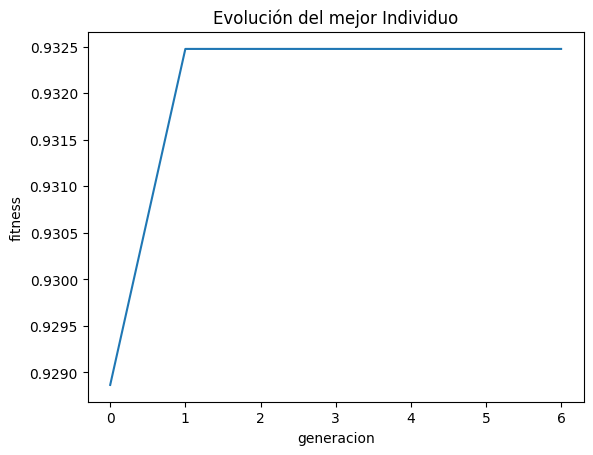

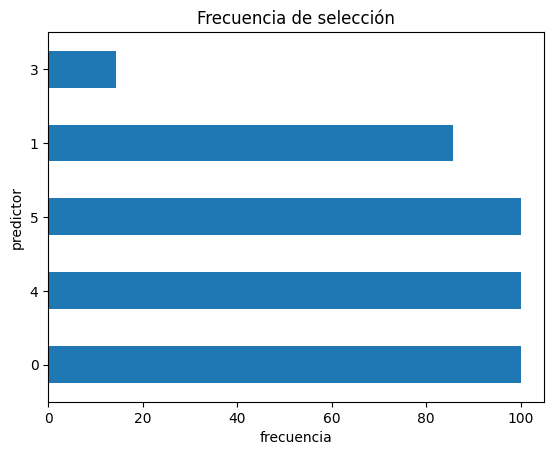

In [10]:
print(poblacion)

# Evolución de la optimización
poblacion.plot_evolucion_fitness()

# Frecuencia relativa selección predictores
poblacion.plot_frecuencia_seleccion()

En la gráfica, se obtiene algo muy parecido a lo que veíamos como "importancia de features" en clases anteriores. Acá se tiene la frecuencia con la que los invididuos de cada generación tomaron dicho predictor, en busca de maximizar su desempeño.



## Ejemplo de clasificador sencillo para contrastar resultados

### Modelo con todos los predictores

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(y_true, y_preds, labels=None, model_name=None, normalize=None):
    """
    Función para graficar la Matrix de confusión
    y_true: vector de salida real
    y_predic: vector de salida predicho por el modelo
    labels: opcional, para nombrar las clases. Lista con strings
    model_name: opcional, para poner un título al gráfico
    normalize: {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    """
    if normalize:
        cm = confusion_matrix(y_true, y_preds, normalize=normalize)
    else:
        cm = confusion_matrix(y_true, y_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    cmd.plot()
    cmd.ax_.set(xlabel='Clase Predicha', ylabel='Clase Real')
    if model_name:
        cmd.ax_.set(title=model_name)

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=1)
tree_clf.fit(X_train, y_train)
pred = tree_clf.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, pred))
print("Classification Report: \n", classification_report(y_test, pred))

Accuracy Score:  0.8989169675090253
Classification Report: 
               precision    recall  f1-score   support

           1       0.94      0.96      0.95       179
           2       0.91      0.88      0.89       157
           3       0.75      0.82      0.79        51
           4       0.89      0.88      0.89       167

    accuracy                           0.90       554
   macro avg       0.87      0.88      0.88       554
weighted avg       0.90      0.90      0.90       554



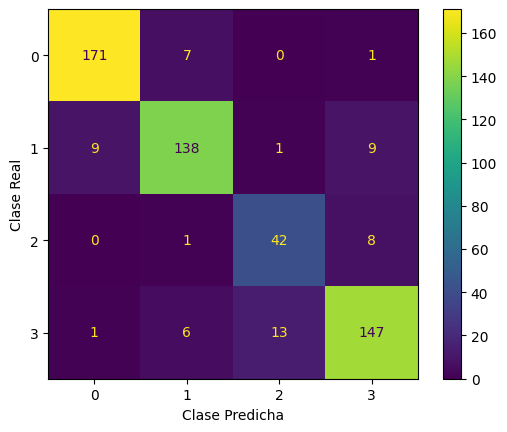

In [13]:
plot_confusion_matrix(y_test, pred)

### Modelo con los predictores de AG

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X[:,2:], y, test_size=0.3, random_state=1)

In [15]:
tree_clf_AG = DecisionTreeClassifier(random_state=1)
tree_clf_AG.fit(X_train, y_train)
pred = tree_clf_AG.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, pred))
print("Classification Report: \n", classification_report(y_test, pred))

Accuracy Score:  0.9314079422382672
Classification Report: 
               precision    recall  f1-score   support

           1       0.97      0.97      0.97       179
           2       0.94      0.92      0.93       157
           3       0.83      0.78      0.81        51
           4       0.91      0.94      0.93       167

    accuracy                           0.93       554
   macro avg       0.91      0.91      0.91       554
weighted avg       0.93      0.93      0.93       554



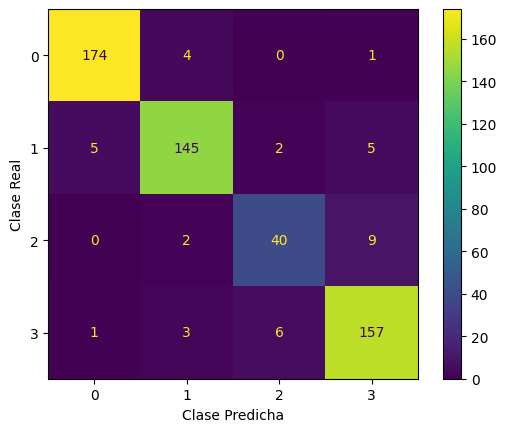

In [16]:
plot_confusion_matrix(y_test, pred)

Ahora utilizo 4 predictor en lugar de 6, y el modelo funciona mejor (confunde menos observaciones para todas las clases). No siempre ocurre de esta manera, pero se logra optimizar; sólo en flujo de datos de entrada se reduce 1/3 de lo que se necesita procesar. Aparte, mejora el desempeño el precisión del modelo.
El costo computacional para la obtención de los predictores... es casi ínfimo.
Pueden testear con otros modelos de predicción.